In [1]:
!pip install pennylane
!pip install scipy
!pip install matplotlib
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 45.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
import random
from numpy import linalg as LA
from numpy.linalg import inv
from scipy.linalg import schur, eigvals
from scipy.linalg import sqrtm
from scipy.optimize import curve_fit
from tqdm import tqdm


/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(



# Defining the single qubit Clifford group:

In [3]:
single_qubit_cliffords = [
 'HH',
 'H', 'S',
 'HS', 'SH', 'SS',
 'HSH', 'HSS', 'SHS', 'SSH', 'SSS',
 'HSHS', 'HSSH', 'HSSS', 'SHSS', 'SSHS',
 'HSHSS', 'HSSHS', 'SHSSH', 'SHSSS', 'SSHSS',
 'HSHSSH', 'HSHSSS', 'HSSHSS']

# Generator set:
generators=['H','S']
# -

Let us consider an example that illustrates all the steps entailed in the standard RB method. In this spirit, we imagine a situation where we would like to benchmark a set of 1-qubit Clifford gates. We will assume that the gates deviate from their ideal _behaviour_ by considering the following simplified error model:

$$\begin{equation}
\Lambda(\rho) = \sum^3_{i=0} \; p_i \; P_i \rho P_i \; .
\end{equation}$$

 While $\Lambda$ is not the most generic error model in the 1-qubit basis, it allows us to analyticaly predict the value of the effective depolarizing parameter (=$\alpha$), and in this way get a straightforward metric to judge the accuracy of our estimates for $\alpha$.

Here we use the notation where the set $\{p_i\}_i$ symbolizes the probability distribution over the 1-qubit Pauli group. The operators $P_i$ are the Pauli matrices, with the correspondence: $P_0=\mathbb{1}$, $P_1=X$, $P_2=Y$ and $P_3=Z$. Before running our RB experiment, we randomly assign values to the probability distribution set $\{p_i\}_i$. This random assignment is made under the constraint: $\sum^3_{i=0} p_i=1$. This condition guarantees that $\Lambda$ is a trace preserving map. We then assume that every gate in our circuit is _corrupted_ by noise in an homogeneous way, and that $\Lambda$ is a _good_ representation of this noise. Note that this fulfills the usual assumption of RB, requiring a gate and time-indepenednt error model.

In [4]:
## Necessary functions for randomised benchmarking

dev = qml.device("default.mixed", wires=1)


def rand_pi(N,max_bound):
    dict={}
    p1=0.0
    p2=0.0
    p3=0.0
    p0=0.0
    i=1
    while i<=N:
        c3=random.uniform(0,max_bound)
        c1=random.uniform(0,max_bound)
        c2=random.uniform(0,max_bound)

        c0=(1.0-c1-c2-c3)

        p1=p1+c1
        p2=p2+c2
        p3=p3+c3
        p0=p0+c0
        i=i+1

    dict['pI']=p0*(1.0/N)
    dict['pX']=p1*(1.0/N)
    dict['pY']=p2*(1.0/N)
    dict['pZ']=p3*(1.0/N)
    return dict


def rand_Cl1_unimat(list_clifford_strings):
    choice=random.randint(0, len(list_clifford_strings)-1)
    clifford=list_clifford_strings[choice]
    gen_gates=list(clifford)
    g=np.eye(2,dtype=complex)
    for gate in gen_gates:
        if gate == 'H':
            g=np.matmul(g,qml.Hadamard(wires=0).matrix())
        else:
            sign = 1
            g=np.matmul(g,qml.PhaseShift(sign * np.pi/2, wires=0).matrix())
    return g

## Ideal Clifford sequence

In [5]:
def ideal_Clifford_circuit(C,Ci):
    qml.QubitUnitary(C, wires=0) # Corresponds to C_m...C_2 C_1|0><0|C_1^{\dagger} C_2^{\dagger}...C_m^{\dagger}
    qml.QubitUnitary(Ci, wires=0) # Corresponds to applying the inverse of the previous sequence.
    return qml.state()


def sequence_matrices(list_clifford_strings,m):
    seq_ideal=np.eye(2,dtype=complex)
    seq_ideal_inv=np.eye(2,dtype=complex)
    for i in range(m):
        # Select one Clifford at random:
        C=rand_Cl1_unimat(list_clifford_strings)
        # Compute the sequence operator:
        seq_ideal=np.matmul(C,seq_ideal)
    seq_ideal_inv=seq_ideal.conj().T
    return seq_ideal,seq_ideal_inv

## Noisy Clifford sequence

In [6]:
def sequence_matrices_noise(list_clifford_strings,m):
    dict_mat={}
    seq_ideal=np.eye(2,dtype=complex)
    seq_ideal_inv=np.eye(2,dtype=complex)
    for i in range(m):
        C=rand_Cl1_unimat(list_clifford_strings)
        seq_ideal=np.matmul(C,seq_ideal)
        dict_mat[str(i)]=C
    seq_ideal_inv=seq_ideal.conj().T
    dict_mat[str(i+1)]=seq_ideal_inv
    return dict_mat


def noisy_Clifford_sequence(dict,m,paulis):
    K0= np.sqrt(paulis['pI'])*np.eye(2)
    K1= np.sqrt(paulis['pX'])*np.array([[0.0,1.0],[1.0,0.0]])
    K2= np.sqrt(paulis['pY'])*np.array([[0.0,0.0-1j],[0.0+1j,0.0]])
    K3= np.sqrt(paulis['pZ'])*np.array([[1.0,0.0],[0.0,-1.0]])
    for i in range(m):
        qml.QubitUnitary(dict[str(i)], wires=0,id="Clifford"+"_"+str(i)) # Corresponds to C|0><0|C^{\dagger}
    # Adding the noise:
        qml.QubitChannel([K0, K1, K2, K3], wires=0)

    qml.QubitUnitary(dict[str(i+1)], wires=0,id="Clifford inv")
    qml.QubitChannel([K0, K1, K2, K3], wires=0)

    return qml.state()

## Depolarising channel related functions of RB

In [7]:
def standardRB_exp(Gamma,K_tot,m_list,stats_on):
    results={}
    fidelities = []
    if stats_on:
        stats_mat=np.zeros((K_tot,len(m_list)),dtype=complex)
        idx=0

    for m in tqdm(m_list):
        res=0.0
        for K in np.arange(K_tot):
            # Computing sequence of Clifford matrices to use:
            seq_op,seq_op_inv=sequence_matrices(single_qubit_cliffords,m)
            dict=sequence_matrices_noise(single_qubit_cliffords,m)
            # Initialize QNodes:
            ideal_qnode = qml.QNode(ideal_Clifford_circuit, dev)
            noisy_qnode = qml.QNode(noisy_Clifford_sequence, dev)
            # Execute the QNodes:
            ideal_state = ideal_qnode(seq_op,seq_op_inv)
            noisy_state = noisy_qnode(dict,m,Gamma)
            # Compute the fidelity:
            F=np.trace(np.matmul(ideal_state,noisy_state))
            if stats_on:
                stats_mat[K,idx]=F
            res=res+F
        # Averaged fidelity:
        res=res/(K+1)
        # Save average fidelity results:
        fidelities.append(res)
        if stats_on:
            idx=idx+1

    results['m']=m_list
    results['F_ave']=fidelities
    results['prob_dist']=Gamma
    if stats_on:
        results['F_mat']=stats_mat
    return results

# Function defining the expected behaviour for the average gate fidelity
# (the theoretical model for standard RB):

In [8]:
def theorectical_model_standardRB(m,A0, B0, p):
    return A0*p**m + B0

In [9]:


# +
def fidelity_theory(res,m):
    Pdis=res['prob_dist']
    p0=Pdis['pI']
    px=Pdis['pX']
    py=Pdis['pY']
    B0=0.5
    c3=1.0-2.0*(px+py)
    A0=0.5*c3
    alpha=(1/3)*(4*p0-1)
    f=B0+A0*alpha**m
    return f


def var_RB(res):
    s=np.array(res['F_mat'].shape)
    m_len=s[1]
    N=s[0]
    mat=res['F_mat'].real
    mat_ave=fidelity_theory(res,np.array(res['m']))
    sum_f=0.0
    var_vec=[]
    for idx_col in np.arange(m_len):
        f_ave=mat_ave[idx_col]
        for idx_line in np.arange(N):
            f=mat[idx_line,idx_col]
            sum_f=sum_f+(f-f_ave)**2
        sum_f=sum_f/N
        var_vec.append(sum_f)
    return np.array(var_vec)

def mean_error_RB(res):
    me_vec=abs(np.array(res['F_ave']).real-fidelity_theory(res,np.array(res['m'])))
    return np.array(me_vec)

def alpha_error_RB(res):
    Pdis=res['prob_dist']
    p0=Pdis['pI']
    alpha_theory=(1/3)*(4*p0-1)
    s=np.array(res['F_mat'].shape)
    m_len=s[1]
    Fnum_vec=np.array(res['F_ave']).real
    m_vec=np.array(res['m'])
    popt, pcov = curve_fit(theorectical_model_standardRB, m_vec, Fnum_vec, bounds=(0, [0.5, 0.5, 1.]))
    alpha=popt[2]
    error=abs(alpha-alpha_theory)

    return error

## Construction of random gate sequences

In [10]:
def selected_random_gates(m_max,K_tot,list_clifford_strings):
    gates_vec=[]
    for n in np.arange(K_tot*m_max):
        g = rand_Cl1_unimat(list_clifford_strings)
        gates_vec.append(g)

    return gates_vec


## Defintion of frame potential (required to determine 2-design property)

In [11]:
def frame_potential(vec):
    N=len(vec)
    res=0.0
    vec_res=[]
    for i in np.arange(N):
        Ud=vec[i]
        Ud=Ud.conj().T
        for j in np.arange(N):
            U=vec[j]
            f=np.abs(np.trace(np.matmul(Ud,U)))**4
            f=f/(N*N)
            res=res+f
    return res


# +
# Starting from the generator set and expanding:

def add_to_gen(gen_set,full_set,N):
    set=gen_set.copy()
    for n in np.arange(N):
        bol=0
        while(bol==0):
            choice_idx=random.randint(0, len(full_set)-1)
            gate=full_set[choice_idx]
            if gate not in set:
                bol=1
                set.append(gate)
    return set
# -

def compare_circuits(Gamma,K_tot,m_list):
    results={}
    fidelities = []
    p0=Gamma['pI']
    px=Gamma['pX']
    py=Gamma['pY']
    pz=Gamma['pZ']
    c=p0-px-py+pz
    alpha=(1/3)*(4*p0-1)
    I=np.eye(2,dtype=complex)
    Z=np.zeros((2,2),dtype=complex)
    Z[0,0]=1.0+0.0*1j
    Z[1,1]=-1.0+0.0*1j
    rho_0=0.5*(I+Z)

    for m in tqdm(m_list):
        res=0.0
        rho_dep=0.5*I+(alpha**m)*0.5*c*Z
        sqrt_sigma = sqrtm(rho_dep)
        rho_final = np.zeros((2,2),dtype=complex)
        for K in np.arange(K_tot):
            # Computing sequence of Clifford matrices to use:
            dict=sequence_matrices_noise(single_qubit_cliffords,m)
            # Initialize QNode:
            noisy_qnode = qml.QNode(noisy_Clifford_sequence, dev)
            # Execute the QNode:
            noisy_state = noisy_qnode(dict,m,Gamma)
            # Extract rho at the end of the circuit (averge):
            rho_final = rho_final + noisy_state
        # Averaged rho:
        rho_final = rho_final/(K+1)
        # Save average results:
        results[str(m)]=abs(abs(rho_final-rho_dep))

    results['m']=m_list
    results['prob_dist']=Gamma

    return results


In the following, the function __standardRB_exp__ executes the RB experiment, and therefore its output will store of the average fidelity for each value of the circuit's lenght (m). Once data on the fidelity is collected, we can proceed by fitting it to the usual RB model. This fitting allows us to estimate $\alpha$, which is the most important parameter to be learnt from the standard RB data. Recall that the average error rate over our Clifford gate set will be given by:
$$\begin{equation}
r=\frac{(2^n-1)(1-\alpha)}{2^n} \underset{n=1}{=} \frac{(1-\alpha)}{2}
\end{equation}$$

Thus, once we estimate $\alpha$ we will be able to quantify, on average, how noisy our gates are.

In [12]:
# Collecting RB data:
Gamma1=rand_pi(100,0.01)
K_tot=100
stats_on=0
m_list=[1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
results_1=standardRB_exp(Gamma1,K_tot,m_list,stats_on)

Gamma2=rand_pi(100,0.15)
K_tot=100
stats_on=0
results_2=standardRB_exp(Gamma2,K_tot,m_list,stats_on)

100%|██████████| 28/28 [01:43<00:00,  3.69s/it]


In [13]:
# Set of probability distributions assigned to our error models:
print(Gamma1)
print(Gamma2)

{'pI': 0.9850477024128328, 'pX': 0.005024072851790964, 'pY': 0.004972830313755024, 'pZ': 0.0049553944216210715}
{'pI': 0.7732996108773724, 'pX': 0.07223807001334348, 'pY': 0.07783953370873965, 'pZ': 0.07662278540054444}


<a id="2"></a>
#### Fitting the RB data to extract $\alpha$

# Fitting theoretical model:

In [14]:
# Lower noise level case:
m_data1= np.array(results_1['m'])
ydata1 = np.array(results_1['F_ave']).real
popt1, pcov1 = curve_fit(theorectical_model_standardRB, m_data1, ydata1, bounds=(0, [0.5, 0.5, 1.]))

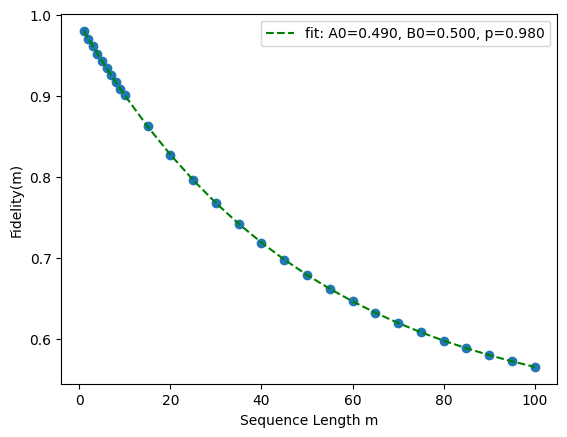

In [15]:
plt.scatter(m_data1,ydata1);
plt.plot(m_data1, theorectical_model_standardRB(m_data1, *popt1), 'g--',
        label='fit: A0=%5.3f, B0=%5.3f, p=%5.3f' % tuple(popt1))
plt.xlabel('Sequence Length m'); plt.ylabel('Fidelity(m)');
plt.legend();

In [16]:
# Higher noise level case:
m_data2= np.array(results_2['m'])
ydata2 = np.array(results_2['F_ave']).real
popt2, pcov2 = curve_fit(theorectical_model_standardRB, m_data2, ydata2, bounds=(0, [0.5, 0.5, 1.]))

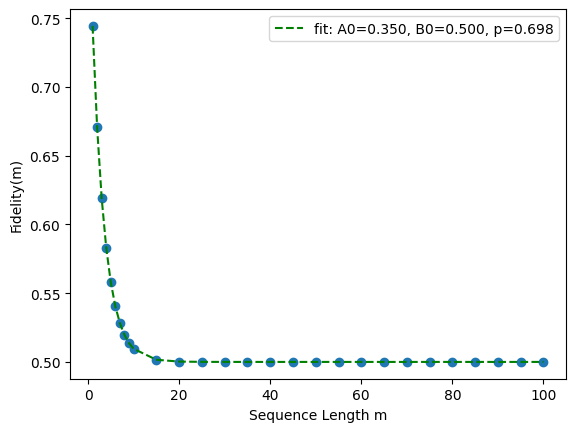

In [17]:
plt.scatter(m_data2,ydata2);
plt.plot(m_data2, theorectical_model_standardRB(m_data2, *popt2), 'g--',
        label='fit: A0=%5.3f, B0=%5.3f, p=%5.3f' % tuple(popt2))
plt.xlabel('Sequence Length m'); plt.ylabel('Fidelity(m)');
plt.legend();

Our choice for $\Lambda$ makes it particularly easy to analytically predict the values of the RB parameters $A_0$, $B_0$ and $\alpha$. These can be shown to read (see notes for details):
$$\begin{equation}
\begin{split}
& \;\; A_0=\frac{(1-2\;(p_1+p_2) \;)}{2} \\
& \\
& \;\; B_0 =\frac{1}{2} \\
& \\
& \;\; \alpha = \frac{(4 p_0 - 1)}{3}  \; .
\end{split}
\end{equation}$$

Recall that the analytical framework behind the RB model predicts that the average sequence fidelity decays as function of the cicuit's lenghth (m) as:
$$\begin{equation}
F_{\text{ave}}(m) = B_0 + A_0 \; \alpha^m \;.
\end{equation}$$

Thus, the higher the noise level, the more $p_0$ should depart from unity, and the more $\alpha$ will decrease. This will result in a fidelity that decays rapidly towards $B_0$, as seen above. Below, we compare our numerical estimates of the RB parameters with their expected theoretical values.

# Comparison with theoretical predictions:

In [18]:
# Lower noise level case:

Pdis=results_1['prob_dist']
p0=Pdis['pI']
px=Pdis['pX']
py=Pdis['pY']

# A0_predicted:
c3=1.0-2.0*(px+py)
print("A0_predicted = {0}".format(0.5*c3))

# A0_predicted -  A0_fit:
print("A0_predicted -  A0_fit = {0}".format(0.5*c3-popt1[0]))

# B0_predicted -  B0_fit:
print("B0_predicted -  B0_fit = {0}".format(0.5-popt1[1]))

# alpha predicted:
a=(1/3)*(4.0*p0-1.0)
print("alpha_predicted = {0}".format(a))
# alpha_predicted -  alpha_fit:
print("alpha_predicted -  alpha_fit = {0}".format(a-popt1[2]))

A0_predicted = 0.49000309683445403
A0_predicted -  A0_fit = -1.0287915519657798e-05
B0_predicted -  B0_fit = 7.96716069084713e-06
alpha_predicted = 0.9800636032171104
alpha_predicted -  alpha_fit = -6.348562850977402e-07


In [19]:
# Higher noise level case:

Pdis=results_2['prob_dist']
p0=Pdis['pI']
px=Pdis['pX']
py=Pdis['pY']

# A0_predicted:
c3=1.0-2.0*(px+py)
print("A0_predicted = {0}".format(0.5*c3))

# A0_predicted -  A0_fit:
print("A0_predicted -  A0_fit = {0}".format(0.5*c3-popt2[0]))

# B0_predicted -  B0_fit:
print("B0_predicted -  B0_fit = {0}".format(0.5-popt2[1]))

# alpha predicted:
a=(1/3)*(4.0*p0-1.0)
print("alpha_predicted = {0}".format(a))
# alpha_predicted -  alpha_fit:
print("alpha_predicted -  alpha_fit = {0}".format(a-popt2[2]))

A0_predicted = 0.3499223962779169
A0_predicted -  A0_fit = -0.0003340276492469485
B0_predicted -  B0_fit = 1.8148441493115453e-05
alpha_predicted = 0.6977328145031632
alpha_predicted -  alpha_fit = 6.654226956814835e-05


<a id="3"></a>
#### Average error rate over the Clifford set

In [20]:
# Error rate for the low level noise case:
r1=0.5*(1.0-popt1[2])
print(r1)

0.009967880963302256


In [21]:
# Error rate for the higher level noise case:
r2=0.5*(1.0-popt2[2])
print(r2)

0.1511668638832025


Now, we will explore how to estimate single-qubit average fidelities using the standard randomized benchmarking (RB) protocol. We will work with the RB data collected with the quantum dot processor described in _"Universal control of a six-qubit quantum processor in silicon"_  __[1]__. Hence, we move from artificial data, to __real__ data from an actual quantum processor.

For the purpose of this notebook, the data has been conveniently stored in a dictionary, with the following structure:
1. Separate RB's were run to benchmark each of the 6 qubits individually. For example, the RB sequence fidelity (as a function of the circuit length) for the first qubit is stored under the key name 'Q1'.
2. The key 'x' stores all the different circuit lengths that were run during the RB protocols. The vector x is the same for all experiments.

We have chosen to focus only on estimating the average fidelity for qubit 1. All the steps are exactly the same for the remaining qubits.

__[1]__: Philips, Stephan GJ, et al. "Universal control of a six-qubit quantum processor in silicon." Nature 609.7929 (2022): 919-924. (https://arxiv.org/abs/2202.09252)

In [23]:
RB_data = {'x': np.array([1.00e+00, 2.00e+00, 3.00e+00, 5.00e+00, 9.00e+00, 1.40e+01,
       2.60e+01, 5.00e+01, 7.00e+01, 1.00e+02, 1.35e+02, 1.90e+02,
       2.50e+02, 4.00e+02, 6.00e+02, 8.00e+02, 1.00e+03, 1.20e+03,
       1.40e+03]), 'Q1': np.array([0.97860568, 0.97945781, 0.97715239, 0.9752579 , 0.9691032 ,
       0.96108464, 0.90994452, 0.84990899, 0.84033637, 0.77286944,
       0.57423182, 0.51099117, 0.5032093 , 0.46817948, 0.53298422,
       0.49498311, 0.56342165, 0.5105064 , 0.48398074]), 'Q2':np.array([0.93964719, 0.93980616, 0.94266741, 0.93893566, 0.93939724,
       0.93109321, 0.92132334, 0.86622842, 0.84672893, 0.82120077,
       0.6830605 , 0.60788889, 0.61738955, 0.53523967, 0.51826644,
       0.49072182, 0.48410207, 0.51264751, 0.50476797]), 'Q3': np.array([0.75465413, 0.75627714, 0.7527482 , 0.75215702, 0.73830031,
       0.72209901, 0.68612275, 0.59452655, 0.49546085, 0.48323578,
       0.43064652, 0.43806021, 0.501421  , 0.49399059, 0.48128486,
       0.4080389 , 0.44789646, 0.41877007, 0.45148769]), 'Q4': np.array([0.79178625, 0.79336355, 0.78320131, 0.79576369, 0.79494562,
       0.78714904, 0.78144445, 0.7177208 , 0.65230787, 0.65693104,
       0.53407103, 0.49175402, 0.43376269, 0.49016893, 0.53440442,
       0.40488942, 0.50424108, 0.48050208, 0.42742204]), 'Q5': np.array([0.88971095, 0.89006047, 0.8900439 , 0.88761169, 0.90465053,
       0.88984549, 0.84875129, 0.70895137, 0.71821967, 0.59108019,
       0.63935327, 0.52459988, 0.46417684, 0.56712439, 0.49606092,
       0.51184542, 0.46698808, 0.49003589, 0.51518838]), 'Q6': np.array([0.982166  , 0.98114439, 0.98191261, 0.97649723, 0.97016441,
       0.96537991, 0.89912152, 0.74663879, 0.68238221, 0.63774165,
       0.50231365, 0.47463534, 0.48756888, 0.52020094, 0.54894665,
       0.4266081 , 0.5350049 , 0.49456684, 0.49012482])}

The following functions define the fitting model that allows us to extract an estimate average fidelity for qubit 1.



1. `theoretical_model_standardRB`

The first function is the familiar RB average sequence fidelity provided in equation __(28)__ of the main text. Note that equation __(28)__ is expressed in terms of __p__, the effective depolarizing parameter in RB. Recall that this term is directly related to the average fidelity through equation __(13)__:
$$\begin{equation}
\bar{F} = p + \frac{1-p}{d} \Leftrightarrow p = 2 \bar{F}-1 \; ,
\end{equation}$$
and $d=2$ for a single qubit system. Here we denote the average gate fidelity by $\bar{F}$. As seen in the lecture notes, the average fidelity quantifies the average fidelity between the noisy Clifford gates and their ideal implementations. However, what we really want to quantify here is the average fidelity of a single qubit operation. So $\bar{F}$ is not quite the final quantity we want to know.

2. `Fav_single_qubit`

In theory *1 Clifford gate = 1 qubit operation*. In practice this is not the case: specifically, all the Clifford gates are achieved by composition of basic qubit rotations. We explain in the main text that in the case considered here, a Clifford gate requires on average 1.875 single-qubit rotations to implement. Since we want to be know the error *per single qubit operation* ($r_{SQ}$), but RB allows us to quantify the average error *per Clifford* ($r_{C_1}$), we need to adjust the estimate of the error rate from point 1. like so

$$\begin{equation}
r_{C_1} = 1.875 \; r_{SQ} \implies \bar{F}_{SQ} = 1 - r_{SQ} \Leftrightarrow \bar{F}_{SQ}= 1 - \frac{(1-\bar{F})}{1.875} \; ,
\end{equation}$$

where $r_{C_1}$ is the average error rate per Clifford, $r_{SQ}$ is the average error rate per single-qubit operation, $\bar{F}$ is the average gate fidelity for the Clifford gate set, and $\bar{F}_{SQ}$ is the average single-qubit gate fidelity. This last fidelity, $\bar{F}_{SQ}$, is what we want to be able to quantify at the end of the protocol.

3. `twosigma_error`

This function allows us to estimate the margin of error corresponding to $2\sigma$ standard errors for the computed single-qubit average fidelity. The Scipy `curve_fit` provides an estimate of the convariance matrix associated with the uncertainty in the estimated value of the parameters. The diagonal entries in this matrix correspond to the variance of the parameter estimates. Thus, we can use the diagonal elements to obtain an estimate for the standard errors, and provide an approximate margin of error for the estimated value of $\bar{F}_{SQ}$ as $\bar{F}_{SQ} \pm 2 \sigma$.

In [24]:
# Auxiliary function definition:

def theorectical_model_standardRB(m,A0, B0, F_avg):
    return A0*(2.0*F_avg-1.0)**m + B0

def Fav_single_qubit(val):
    return 1.0-(1.0-val)/1.875

def twosigma_error(popt,pcov):
    delta_plus=Fav_single_qubit(popt[2]+2.0*np.sqrt(np.diag(pcov1))[2])
    delta_minus=Fav_single_qubit(popt[2]-2.0*np.sqrt(np.diag(pcov1))[2])
    delta =np.abs(delta_plus-delta_minus)
    delta = delta*100.0
    return delta

In [25]:
# Fitting the RB data to the RB decay model:
x=RB_data['x']
seqF_Q1=RB_data['Q1']

popt1, pcov1 = curve_fit(theorectical_model_standardRB,
                         x, seqF_Q1, bounds=(0.0, [1.0, 1.0,1.]))

Note that there is now no error model to fall back on. This prevents us from having a _ground-truth_ value against which to compare our estimate of fidelity. It is then important to look at statistical measures that allow us to quantify the uncertainty in our estimates, such as the construction of confidence intervals. One library that allows for more robust construction of confidence intervals is the LMFIT library (https://lmfit.github.io/lmfit-py/).

For the sake of simplicity, we have chosen to use the more standard scipy `curve_fit` function, but we of course encourae the reader to explore the LMFIT functions as well.

In [26]:
# Optimal value of the parameters ± 2*Standard Deviation:
print('A0 =', popt1[0], "±", pcov1[0,0]**0.5)
print("B0 =", popt1[1], "±", pcov1[1,1]**0.5)
print("Average Fidelity (gate-set) =", popt1[2]*100, "±",  2.0*pcov1[2,2]**0.5*100, "(%)")
print("Average Fidelity (single qubit)= {0} ± {1} (%)".format(Fav_single_qubit(popt1[2])*100,
                                                         twosigma_error(popt1,pcov1)))

A0 = 0.5117235088840789 ± 0.026176225612014034
B0 = 0.4962872292632395 ± 0.019057163288083247
Average Fidelity (gate-set) = 99.54487607643048 ± 0.1376224346067406 (%)
Average Fidelity (single qubit)= 99.75726724076293 ± 0.14679726358052259 (%)


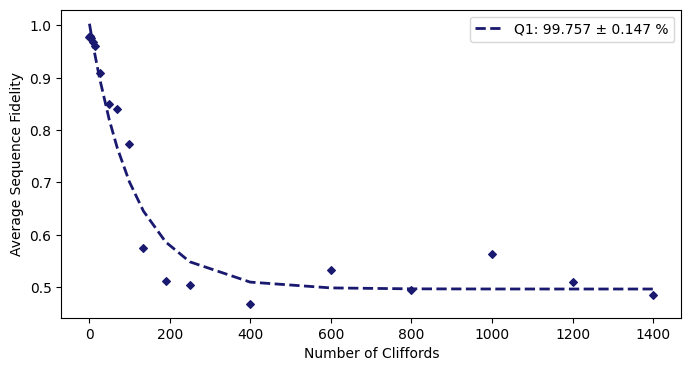

In [27]:
# RB sequence fidelity versus random Clifford sequence length:
plt.figure(figsize=(8,4))
plt.scatter(x,seqF_Q1,marker="D",s=15,color='midnightblue')
plt.plot(x, theorectical_model_standardRB(x, *popt1),color='midnightblue' ,ls='--',linewidth=2.0,
        label='Q1: {0} ± {1} %'.format(round(Fav_single_qubit(popt1[2])*100,3),
                                       round(twosigma_error(popt1,pcov1),3)));
plt.xlabel('Number of Cliffords')
plt.ylabel('Average Sequence Fidelity')

plt.legend();

## Barren plateau


## Theory Behind the Random Variational Circuit
## 1. Variational Quantum Circuits (VQCs)

A *Variational Quantum Circuit* (VQC) is a parameterized quantum circuit of the form

\begin{align}
|\psi(\boldsymbol\theta)\rangle = U(\boldsymbol\theta) |0\rangle,\nonumber
\end{align}

where the unitary ($U(\boldsymbol\theta)$) is built using rotation gates, entanglers, and possibly random choices of gates.

The optimization objective is usually to minimize an expectation value,

\begin{align}
C(\boldsymbol\theta) = \langle \psi(\boldsymbol\theta) | H | \psi(\boldsymbol\theta)\rangle.\nonumber
\end{align}

This is exactly what the circuit returns,

\begin{align}
C(\theta) = \langle \psi(\theta) | H | \psi(\theta)\rangle,\nonumber
\end{align}
where
\begin{align}
H = |0000\rangle\langle 0000| .\nonumber
\end{align}

---

## 2. **Initialization With a Fixed Layer**

The code starts with:

```python
for i in range(num_qubits):
    qml.RY(np.pi / 4, wires=i)
```

This is a deterministic layer that takes each qubit away from ($|0\rangle$):
\begin{align}
|\psi_1\rangle = \bigotimes_{i} R_Y(\pi/4)|0\rangle.\nonumber
\end{align}

This avoids starting in a trivial state.

---

## 3. **Random Parameterized Layer (Source of Barren Plateaus)**

```python
random_gate_sequence[i](params[i], wires=i)
```

Each qubit receives a gate chosen randomly from:

\begin{align}
{ R_X, R_Y, R_Z }.\nonumber
\end{align}

This produces a circuit of the form:

\begin{align}
U(\theta) = \prod_{i=1}^n G_i(\theta_i),\nonumber
\end{align}
where ($G_i$) is a randomly sampled single-qubit rotation.
**Why this matters:**
When random local rotations are applied, the resulting state can become *concentrated* around the Haar-random distribution for sufficiently deep or wide circuits.

---
## 4. **Entangling Layer**

```python
for i in range(num_qubits - 1):
    qml.CZ(wires=[i, i+1])
```

This creates a chain of controlled-Z entanglers:

\begin{align}
U_{\text{CZ}} = \prod_{i=1}^{n-1} \text{CZ}_{i,i+1}.\nonumber
\end{align}

Entanglement is necessary for expressive models—but too much random entanglement + random rotations → quickly pushes the state into the *concentration of measure* regime.

---
## 5. **Measurement Hamiltonian**
The Hamiltonian is,
```python
H = np.zeros((2 ** num_qubits, 2 ** num_qubits))
H[0, 0] = 1
```

That is
\begin{align}
H = |0000\rangle\langle 0000|.\nonumber
\end{align}
So the cost function is simply:
\begin{align}
C(\theta) = \Pr(\text{measuring } 0000 \text{ in computational basis}).\nonumber
\end{align}
This is a *local observable* (non-extensive), which in principle helps reduce barren plateaus—but random circuits still generate plateaus depending on depth/randomness.

---
# 6. Why This Circuit Exhibits a Barren Plateau

A **barren plateau** occurs when:

\begin{align}
\mathbb{E}[ \nabla C(\theta)| ] \to 0 \quad \text{exponentially fast in } n.\nonumber
\end{align}

This happens because:

### The circuit contains random single-qubit gates

Random gates push the state toward a **Haar-random state**.

### Followed by an entangling layer

Entanglement spreads "randomness" across qubits, producing an approximate **2-design**, which is enough to trigger concentration of measure.

### The gradient of local observables vanishes in random deep circuits

For a typical random circuit, the gradient satisfies:

\begin{align}
\mathrm{Var}[\partial C / \partial \theta] \sim \mathcal{O}(1/2^n).\nonumber
\end{align}

This exponential suppression is the hallmark of a barren plateau.

Even though the cost is local, your circuit *still* experiences vanishing gradients due to the randomization depth + entangling structure.

---

# 7. Interpreting Circuit’s Cost Value

Because:

* the parameters are random,
* the circuit becomes nearly Haar-random,
* the projection onto ($|0000\rangle$) has expectation:

\begin{align}
\mathbb{E}[C(\theta)] = \frac{1}{2^n},\nonumber
\end{align}

for (n=4):

\begin{align}
\mathbb{E}[C] \approx \frac{1}{16} = 0.0625.\nonumber
\end{align}

This explains why:

* The cost fluctuates near a small value,
* Gradients vanish,
* Optimization becomes ineffective → **barren plateau**.

---

In [28]:
# Set a seed for reproducibility
np.random.seed(42)

num_qubits = 4
dev = qml.device("default.qubit", wires=num_qubits)
gate_set = [qml.RX, qml.RY, qml.RZ]


def rand_circuit(params, random_gate_sequence=None, num_qubits=None):
    """A random variational quantum circuit.

    Args:
        params (array[float]): array of parameters
        random_gate_sequence (dict): a dictionary of random gates
        num_qubits (int): the number of qubits in the circuit

    Returns:
        float: the expectation value of the target observable
    """
    for i in range(num_qubits):
        qml.RY(np.pi / 4, wires=i)

    for i in range(num_qubits):
        random_gate_sequence[i](params[i], wires=i)

    for i in range(num_qubits - 1):
        qml.CZ(wires=[i, i + 1])

    H = np.zeros((2 ** num_qubits, 2 ** num_qubits))
    H[0, 0] = 1
    wirelist = [i for i in range(num_qubits)]
    return qml.expval(qml.Hermitian(H, wirelist))

In [29]:
grad_vals = []
num_samples = 200

for i in range(num_samples):
    gate_sequence = {i: np.random.choice(gate_set) for i in range(num_qubits)}
    qcircuit = qml.QNode(rand_circuit, dev, interface="autograd")
    grad = qml.grad(qcircuit, argnum=0)
    params = np.random.uniform(0, 2 * np.pi, size=num_qubits)
    gradient = grad(params, random_gate_sequence=gate_sequence, num_qubits=num_qubits)
    grad_vals.append(gradient[-1])

print("Variance of the gradients for {} random circuits: {}".format(
    num_samples, np.var(grad_vals)
    )
)
print("Mean of the gradients for {} random circuits: {}".format(
    num_samples, np.mean(grad_vals)
    )
)

Variance of the gradients for 200 random circuits: 0.0060200187991571
Mean of the gradients for 200 random circuits: -0.0008770836210344132


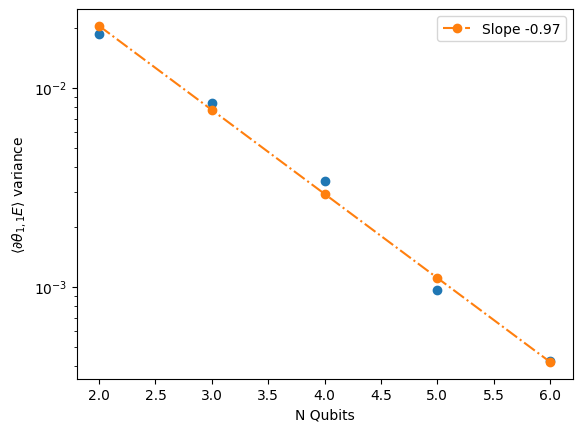

In [30]:
qubits = [2, 3, 4, 5, 6]
variances = []


for num_qubits in qubits:
    grad_vals = []
    for i in range(num_samples):
        dev = qml.device("default.qubit", wires=num_qubits)
        qcircuit = qml.QNode(rand_circuit, dev, interface="autograd")
        grad = qml.grad(qcircuit, argnum=0)

        gate_set = [qml.RX, qml.RY, qml.RZ]
        random_gate_sequence = {i: np.random.choice(gate_set) for i in range(num_qubits)}

        params = np.random.uniform(0, np.pi, size=num_qubits)
        gradient = grad(
            params, random_gate_sequence=random_gate_sequence, num_qubits=num_qubits
        )
        grad_vals.append(gradient[-1])
    variances.append(np.var(grad_vals))

variances = np.array(variances)
qubits = np.array(qubits)


# Fit the semilog plot to a straight line
p = np.polyfit(qubits, np.log(variances), 1)


# Plot the straight line fit to the semilog
plt.semilogy(qubits, variances, "o")
plt.semilogy(qubits, np.exp(p[0] * qubits + p[1]), "o-.", label="Slope {:3.2f}".format(p[0]))
plt.xlabel(r"N Qubits")
plt.ylabel(r"$\langle \partial \theta_{1, 1} E\rangle$ variance")
plt.legend()
plt.show()